In [ ]:
import csv
import os

import numpy as np
import pandas as pd
from epiweeks import Week

from data_downloader import GenerateTrainingData
from utils import date_today, gravity_law_commute_dist

os.environ['NUMEXPR_MAX_THREADS'] = '16'
os.environ['NUMEXPR_NUM_THREADS'] = '8'

import pickle
import matplotlib.pyplot as plt
import dgl
import torch
from torch import nn
import torch.nn.functional as F
from model import STAN

import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [ ]:
GenerateTrainingData().download_jhu_data('2020-05-01', '2020-12-01')

In [ ]:
#Merge population data with downloaded data
raw_data = pickle.load(open('./data/state_covid_data.pickle','rb'))
pop_data = pd.read_csv('./uszips.csv')
pop_data = pop_data.groupby('state_name').agg({'population':'sum', 'density':'mean', 'lat':'mean', 'lng':'mean'}).reset_index()
raw_data = pd.merge(raw_data, pop_data, how='inner', left_on='state', right_on='state_name')

In [ ]:
raw_data.head(3)

In [ ]:
# Generate location similarity
loc_list = list(raw_data['state'].unique())
loc_dist_map = {}

for each_loc in loc_list:
    loc_dist_map[each_loc] = {}
    for each_loc2 in loc_list:
        lat1 = raw_data[raw_data['state']==each_loc]['latitude'].unique()[0]
        lng1 = raw_data[raw_data['state']==each_loc]['longitude'].unique()[0]
        pop1 = raw_data[raw_data['state']==each_loc]['population'].unique()[0]
        
        lat2 = raw_data[raw_data['state']==each_loc2]['latitude'].unique()[0]
        lng2 = raw_data[raw_data['state']==each_loc2]['longitude'].unique()[0]
        pop2 = raw_data[raw_data['state']==each_loc2]['population'].unique()[0]
        
        loc_dist_map[each_loc][each_loc2] = gravity_law_commute_dist(lat1, lng1, pop1, lat2, lng2, pop2, r=0.5)

In [6]:
#Generate Graph
dist_threshold = 18

for each_loc in loc_dist_map:
    loc_dist_map[each_loc] = {k: v for k, v in sorted(loc_dist_map[each_loc].items(), key=lambda item: item[1], reverse=True)}
    
adj_map = {}
for each_loc in loc_dist_map:
    adj_map[each_loc] = []
    for i, each_loc2 in enumerate(loc_dist_map[each_loc]):
        if loc_dist_map[each_loc][each_loc2] > dist_threshold:
            if i <= 3:
                adj_map[each_loc].append(each_loc2)
            else:
                break
        else:
            if i <= 1:
                adj_map[each_loc].append(each_loc2)
            else:
                break

rows = []
cols = []
for each_loc in adj_map:
    for each_loc2 in adj_map[each_loc]:
        rows.append(loc_list.index(each_loc))
        cols.append(loc_list.index(each_loc2))

In [7]:
g = dgl.graph((rows, cols))

In [8]:
#Preprocess features

active_cases = []
confirmed_cases = []
new_cases = []
death_cases = []
static_feat = []

for i, each_loc in enumerate(loc_list):
    active_cases.append(raw_data[raw_data['state'] == each_loc]['active'])
    confirmed_cases.append(raw_data[raw_data['state'] == each_loc]['confirmed'])
    new_cases.append(raw_data[raw_data['state'] == each_loc]['new_cases'])
    death_cases.append(raw_data[raw_data['state'] == each_loc]['deaths'])
    static_feat.append(np.array(raw_data[raw_data['state'] == each_loc][['population','density','lng','lat']]))
    
active_cases = np.array(active_cases)
confirmed_cases = np.array(confirmed_cases)
death_cases = np.array(death_cases)
new_cases = np.array(new_cases)
static_feat = np.array(static_feat)[:, 0, :]
recovered_cases = confirmed_cases - active_cases - death_cases
susceptible_cases = np.expand_dims(static_feat[:, 0], -1) - active_cases - recovered_cases

# Batch_feat: new_cases(dI), dR, dS
#dI = np.array(new_cases)
dI = np.concatenate((np.zeros((active_cases.shape[0],1), dtype=np.float32), np.diff(active_cases)), axis=-1)
dR = np.concatenate((np.zeros((recovered_cases.shape[0],1), dtype=np.float32), np.diff(recovered_cases)), axis=-1)
dS = np.concatenate((np.zeros((susceptible_cases.shape[0],1), dtype=np.float32), np.diff(susceptible_cases)), axis=-1)

In [9]:
#Build normalizer
normalizer = {'S':{}, 'I':{}, 'R':{}, 'dS':{}, 'dI':{}, 'dR':{}}

for i, each_loc in enumerate(loc_list):
    normalizer['S'][each_loc] = (np.mean(susceptible_cases[i]), np.std(susceptible_cases[i]))
    normalizer['I'][each_loc] = (np.mean(active_cases[i]), np.std(active_cases[i]))
    normalizer['R'][each_loc] = (np.mean(recovered_cases[i]), np.std(recovered_cases[i]))
    normalizer['dI'][each_loc] = (np.mean(dI[i]), np.std(dI[i]))
    normalizer['dR'][each_loc] = (np.mean(dR[i]), np.std(dR[i]))
    normalizer['dS'][each_loc] = (np.mean(dS[i]), np.std(dS[i]))

In [10]:
def prepare_data(data, sum_I, sum_R, history_window=5, pred_window=15, slide_step=5):
    # Data shape n_loc, timestep, n_feat
    # Reshape to n_loc, t, history_window*n_feat
    n_loc = data.shape[0]
    timestep = data.shape[1]
    n_feat = data.shape[2]
    
    x = []
    y_I = []
    y_R = []
    last_I = []
    last_R = []
    concat_I = []
    concat_R = []
    for i in range(0, timestep, slide_step):
        if i+history_window+pred_window-1 >= timestep or i+history_window >= timestep:
            break
        x.append(data[:, i:i+history_window, :].reshape((n_loc, history_window*n_feat)))
        
        concat_I.append(data[:, i+history_window-1, 0])
        concat_R.append(data[:, i+history_window-1, 1])
        last_I.append(sum_I[:, i+history_window-1])
        last_R.append(sum_R[:, i+history_window-1])

        y_I.append(data[:, i+history_window:i+history_window+pred_window, 0])
        y_R.append(data[:, i+history_window:i+history_window+pred_window, 1])

    x = np.array(x, dtype=np.float32).transpose((1, 0, 2))
    last_I = np.array(last_I, dtype=np.float32).transpose((1, 0))
    last_R = np.array(last_R, dtype=np.float32).transpose((1, 0))
    concat_I = np.array(concat_I, dtype=np.float32).transpose((1, 0))
    concat_R = np.array(concat_R, dtype=np.float32).transpose((1, 0))
    y_I = np.array(y_I, dtype=np.float32).transpose((1, 0, 2))
    y_R = np.array(y_R, dtype=np.float32).transpose((1, 0, 2))
    return x, last_I, last_R, concat_I, concat_R, y_I, y_R

In [11]:
valid_window = 25
test_window = 25

history_window=6
pred_window=15
slide_step=5

dynamic_feat = np.concatenate((np.expand_dims(dI, axis=-1), np.expand_dims(dR, axis=-1), np.expand_dims(dS, axis=-1)), axis=-1)
    
#Normalize
for i, each_loc in enumerate(loc_list):
    dynamic_feat[i, :, 0] = (dynamic_feat[i, :, 0] - normalizer['dI'][each_loc][0]) / normalizer['dI'][each_loc][1]
    dynamic_feat[i, :, 1] = (dynamic_feat[i, :, 1] - normalizer['dR'][each_loc][0]) / normalizer['dR'][each_loc][1]
    dynamic_feat[i, :, 2] = (dynamic_feat[i, :, 2] - normalizer['dS'][each_loc][0]) / normalizer['dS'][each_loc][1]

dI_mean = []
dI_std = []
dR_mean = []
dR_std = []

for i, each_loc in enumerate(loc_list):
    dI_mean.append(normalizer['dI'][each_loc][0])
    dR_mean.append(normalizer['dR'][each_loc][0])
    dI_std.append(normalizer['dI'][each_loc][1])
    dR_std.append(normalizer['dR'][each_loc][1])

dI_mean = np.array(dI_mean)
dI_std = np.array(dI_std)
dR_mean = np.array(dR_mean)
dR_std = np.array(dR_std)

#Split train-test
train_feat = dynamic_feat[:, :-valid_window-test_window, :]
val_feat = dynamic_feat[:, -valid_window-test_window:-test_window, :]
test_feat = dynamic_feat[:, -test_window:, :]

train_x, train_I, train_R, train_cI, train_cR, train_yI, train_yR = prepare_data(train_feat, active_cases[:, :-valid_window-test_window], recovered_cases[:, :-valid_window-test_window], history_window, pred_window, slide_step)
val_x, val_I, val_R, val_cI, val_cR, val_yI, val_yR = prepare_data(val_feat, active_cases[:, -valid_window-test_window:-test_window], recovered_cases[:, -valid_window-test_window:-test_window], history_window, pred_window, slide_step)
test_x, test_I, test_R, test_cI, test_cR, test_yI, test_yR = prepare_data(test_feat, active_cases[:, -test_window:], recovered_cases[:, -test_window:], history_window, pred_window, slide_step)

In [12]:
#Build STAN model

in_dim = 3*history_window
hidden_dim1 = 32
hidden_dim2 = 32
gru_dim = 32
num_heads = 1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

g = g.to(device)
model = STAN(g, in_dim, hidden_dim1, hidden_dim2, gru_dim, num_heads, pred_window, device).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.MSELoss()

In [13]:
model

STAN(
  (layer1): MultiHeadGATLayer(
    (heads): ModuleList(
      (0): GATLayer(
        (fc): Linear(in_features=18, out_features=32, bias=True)
        (attn_fc): Linear(in_features=64, out_features=1, bias=True)
      )
    )
  )
  (layer2): MultiHeadGATLayer(
    (heads): ModuleList(
      (0): GATLayer(
        (fc): Linear(in_features=32, out_features=32, bias=True)
        (attn_fc): Linear(in_features=64, out_features=1, bias=True)
      )
    )
  )
  (gru): GRUCell(32, 32)
  (nn_res_I): Linear(in_features=34, out_features=15, bias=True)
  (nn_res_R): Linear(in_features=34, out_features=15, bias=True)
  (nn_res_sir): Linear(in_features=34, out_features=2, bias=True)
)

In [14]:
train_x = torch.tensor(train_x).to(device)
train_I = torch.tensor(train_I).to(device)
train_R = torch.tensor(train_R).to(device)
train_cI = torch.tensor(train_cI).to(device)
train_cR = torch.tensor(train_cR).to(device)
train_yI = torch.tensor(train_yI).to(device)
train_yR = torch.tensor(train_yR).to(device)

val_x = torch.tensor(val_x).to(device)
val_I = torch.tensor(val_I).to(device)
val_R = torch.tensor(val_R).to(device)
val_cI = torch.tensor(val_cI).to(device)
val_cR = torch.tensor(val_cR).to(device)
val_yI = torch.tensor(val_yI).to(device)
val_yR = torch.tensor(val_yR).to(device)

test_x = torch.tensor(test_x).to(device)
test_I = torch.tensor(test_I).to(device)
test_R = torch.tensor(test_R).to(device)
test_cI = torch.tensor(test_cI).to(device)
test_cR = torch.tensor(test_cR).to(device)
test_yI = torch.tensor(test_yI).to(device)
test_yR = torch.tensor(test_yR).to(device)

dI_mean = torch.tensor(dI_mean, dtype=torch.float32).to(device).reshape((dI_mean.shape[0], 1, 1))
dI_std = torch.tensor(dI_std, dtype=torch.float32).to(device).reshape((dI_mean.shape[0], 1, 1))
dR_mean = torch.tensor(dR_mean, dtype=torch.float32).to(device).reshape((dI_mean.shape[0], 1, 1))
dR_std = torch.tensor(dR_std, dtype=torch.float32).to(device).reshape((dI_mean.shape[0], 1, 1))

N = torch.tensor(static_feat[:, 0], dtype=torch.float32).to(device).unsqueeze(-1)

In [15]:
#Train STAN

all_loss = []
file_name = './save/stan'
min_loss = 1e10

loc_name = loc_list[0]
cur_loc = 0

#loc_name = 'Kentucky'
#cur_loc = loc_list.index(loc_name)

for epoch in range(50):
    model.train()
    optimizer.zero_grad()
    
    active_pred, recovered_pred, phy_active, phy_recover, _ = model(train_x, train_cI[cur_loc], train_cR[cur_loc], N[cur_loc], train_I[cur_loc], train_R[cur_loc])
    phy_active = (phy_active - dI_mean[cur_loc]) / dI_std[cur_loc]
    phy_recover = (phy_recover - dR_mean[cur_loc]) / dR_std[cur_loc]
    loss = criterion(active_pred.squeeze(), train_yI[cur_loc])+criterion(recovered_pred.squeeze(), train_yR[cur_loc])+0.1*criterion(phy_active.squeeze(), train_yI[cur_loc])+0.1*criterion(phy_recover.squeeze(), train_yR[cur_loc])
    
    loss.backward()
    optimizer.step()
    all_loss.append(loss.item())
    
    model.eval()
    _, _, _, _, prev_h = model(train_x, train_cI[cur_loc], train_cR[cur_loc], N[cur_loc], train_I[cur_loc], train_R[cur_loc])
    val_active_pred, val_recovered_pred, val_phy_active, val_phy_recover, _ = model(val_x, val_cI[cur_loc], val_cR[cur_loc], N[cur_loc], val_I[cur_loc], val_R[cur_loc], prev_h)
    
    val_phy_active = (val_phy_active - dI_mean[cur_loc]) / dI_std[cur_loc]
    val_loss = criterion(val_active_pred.squeeze(), val_yI[cur_loc]) + 0.1*criterion(val_phy_active.squeeze(), val_yI[cur_loc])
    if val_loss < min_loss:    
        state = {
            'state': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
        torch.save(state, file_name)
        min_loss = val_loss
        print('-----Save best model-----')
    
    print('Epoch %d, Loss %.2f, Val loss %.2f'%(epoch, all_loss[-1], val_loss.item()))

/home/ubuntu/.local/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


-----Save best model-----
Epoch 0, Loss 4.56, Val loss 16.08
Epoch 1, Loss 40.49, Val loss 20.66
-----Save best model-----
Epoch 2, Loss 19.65, Val loss 2.82
-----Save best model-----
Epoch 3, Loss 2.52, Val loss 0.41
-----Save best model-----
Epoch 4, Loss 0.82, Val loss 0.19
-----Save best model-----
Epoch 5, Loss 0.51, Val loss 0.18
Epoch 6, Loss 0.40, Val loss 0.21
Epoch 7, Loss 0.36, Val loss 0.24
Epoch 8, Loss 0.35, Val loss 0.26
Epoch 9, Loss 0.36, Val loss 0.27
Epoch 10, Loss 0.35, Val loss 0.26
Epoch 11, Loss 0.33, Val loss 0.26
Epoch 12, Loss 0.32, Val loss 0.24
Epoch 13, Loss 0.30, Val loss 0.19
Epoch 14, Loss 0.28, Val loss 0.21
Epoch 15, Loss 0.27, Val loss 0.19
Epoch 16, Loss 0.27, Val loss 0.22
Epoch 17, Loss 0.24, Val loss 0.19
-----Save best model-----
Epoch 18, Loss 0.25, Val loss 0.18
-----Save best model-----
Epoch 19, Loss 0.22, Val loss 0.17
Epoch 20, Loss 0.24, Val loss 0.17
Epoch 21, Loss 0.23, Val loss 0.18
Epoch 22, Loss 0.21, Val loss 0.19
Epoch 23, Loss 0.21

In [16]:
#Pred with STAN
file_name = './save/stan'
checkpoint = torch.load(file_name)
model.load_state_dict(checkpoint['state'])
optimizer.load_state_dict(checkpoint['optimizer'])
model.eval()


prev_x = torch.cat((train_x, val_x), dim=1)
prev_I = torch.cat((train_I, val_I), dim=1)
prev_R = torch.cat((train_R, val_R), dim=1)
prev_cI = torch.cat((train_cI, val_cI), dim=1)
prev_cR = torch.cat((train_cR, val_cR), dim=1)
prev_active_pred, _, prev_phyactive_pred, _, h = model(prev_x, prev_cI[cur_loc], prev_cR[cur_loc], N[cur_loc], prev_I[cur_loc], prev_R[cur_loc])


test_pred_active, test_pred_recovered, test_pred_phy_active, test_pred_phy_recover, _ = model(test_x, test_cI[cur_loc], test_cR[cur_loc], N[cur_loc], test_I[cur_loc], test_R[cur_loc], h)


In [17]:
print('Estimated beta in SIR model is %.2f'%model.alpha_scaled)
print('Estimated gamma in SIR model is %.2f'%model.beta_scaled)

Estimated beta in SIR model is 0.06
Estimated gamma in SIR model is 0.03


In [18]:
#Cumulate predicted dI
pred_I = []

for i in range(test_pred_active.size(1)):
    cur_pred = (test_pred_active[0, i, :].detach().cpu().numpy() * dI_std[cur_loc].reshape(1, 1).detach().cpu().numpy()) + dI_mean[cur_loc].reshape(1, 1).detach().cpu().numpy()
    #cur_pred = test_pred_phy_active[0, i, :].detach().cpu().numpy()
    cur_pred = (cur_pred + test_pred_phy_active[0, i, :].detach().cpu().numpy()) / 2
    cur_pred = np.cumsum(cur_pred)
    cur_pred = cur_pred + test_I[cur_loc, i].detach().cpu().item()
    pred_I.append(cur_pred)
pred_I = np.array(pred_I)
pred_I = pred_I

In [19]:
pred_I[-1, :]

array([121530.96 , 123828.555, 126236.94 , 128210.78 , 130208.73 ,
       131992.72 , 133353.53 , 135193.83 , 137343.72 , 139658.27 ,
       141793.67 , 143604.95 , 145277.72 , 146975.83 , 149443.75 ],
      dtype=float32)

In [20]:
def get_real_y(data, history_window=5, pred_window=15, slide_step=5):
    # Data shape n_loc, timestep, n_feat
    # Reshape to n_loc, t, history_window*n_feat
    n_loc = data.shape[0]
    timestep = data.shape[1]
    
    y = []
    for i in range(0, timestep, slide_step):
        if i+history_window+pred_window-1 >= timestep or i+history_window >= timestep:
            break
        y.append(data[:, i+history_window:i+history_window+pred_window])
    y = np.array(y, dtype=np.float32).transpose((1, 0, 2))
    return y

In [21]:
I_true = get_real_y(active_cases[:], history_window, pred_window, slide_step)

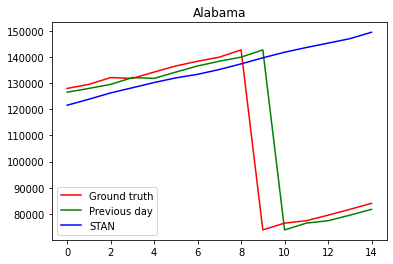

In [22]:
ground_truth = np.array(list(I_true[cur_loc, -1, :]))
previous_day = np.array(list([I_true[cur_loc, -2, 4]]) + list(I_true[cur_loc, -1, :-1]))
predicted = np.array(list(pred_I[-1, :]))
plt.plot(list(range(15)), ground_truth,c='r', label='Ground truth')
plt.plot(list(range(15)), previous_day,c='g', label='Previous day')
plt.plot(list(range(15)), predicted,c='b', label='STAN')
plt.title(loc_name)
plt.legend()
plt.show()

In [23]:
((ground_truth - previous_day) **2).mean()

319916960.0

In [24]:
((ground_truth - predicted) **2).mean()

1739902600.0

In [ ]:
previous_day_mse = 0
predicted_mse = 0

for i in range(52):
    in_dim = 3*history_window
    hidden_dim1 = 32
    hidden_dim2 = 32
    gru_dim = 32
    num_heads = 1
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    g = g.to(device)
    model = STAN(g, in_dim, hidden_dim1, hidden_dim2, gru_dim, num_heads, pred_window, device).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    criterion = nn.MSELoss()
    
    all_loss = []
    file_name = './save/stan'
    min_loss = 1e10

    loc_name = loc_list[i]
    cur_loc = i
    
    for epoch in range(50):
        
        model.train()
        optimizer.zero_grad()

        active_pred, recovered_pred, phy_active, phy_recover, _ = model(train_x, train_cI[cur_loc], train_cR[cur_loc], N[cur_loc], train_I[cur_loc], train_R[cur_loc])
        phy_active = (phy_active - dI_mean[cur_loc]) / dI_std[cur_loc]
        phy_recover = (phy_recover - dR_mean[cur_loc]) / dR_std[cur_loc]
        loss = criterion(active_pred.squeeze(), train_yI[cur_loc])+criterion(recovered_pred.squeeze(), train_yR[cur_loc])+0.1*criterion(phy_active.squeeze(), train_yI[cur_loc])+0.1*criterion(phy_recover.squeeze(), train_yR[cur_loc])

        loss.backward()
        optimizer.step()
        all_loss.append(loss.item())

        model.eval()
        _, _, _, _, prev_h = model(train_x, train_cI[cur_loc], train_cR[cur_loc], N[cur_loc], train_I[cur_loc], train_R[cur_loc])
        val_active_pred, val_recovered_pred, val_phy_active, val_phy_recover, _ = model(val_x, val_cI[cur_loc], val_cR[cur_loc], N[cur_loc], val_I[cur_loc], val_R[cur_loc], prev_h)

        val_phy_active = (val_phy_active - dI_mean[cur_loc]) / dI_std[cur_loc]
        val_loss = criterion(val_active_pred.squeeze(), val_yI[cur_loc]) + 0.1*criterion(val_phy_active.squeeze(), val_yI[cur_loc])
        if val_loss < min_loss:    
            state = {
                'state': model.state_dict(),
                'optimizer': optimizer.state_dict(),
            }
            torch.save(state, file_name)
            min_loss = val_loss
            print('-----Save best model-----')

        print('Epoch %d, Loss %.2f, Val loss %.2f'%(epoch, all_loss[-1], val_loss.item()))
        
    file_name = './save/stan'
    checkpoint = torch.load(file_name)
    model.load_state_dict(checkpoint['state'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    model.eval()


    prev_x = torch.cat((train_x, val_x), dim=1)
    prev_I = torch.cat((train_I, val_I), dim=1)
    prev_R = torch.cat((train_R, val_R), dim=1)
    prev_cI = torch.cat((train_cI, val_cI), dim=1)
    prev_cR = torch.cat((train_cR, val_cR), dim=1)
    prev_active_pred, _, prev_phyactive_pred, _, h = model(prev_x, prev_cI[cur_loc], prev_cR[cur_loc], N[cur_loc], prev_I[cur_loc], prev_R[cur_loc])

    test_pred_active, test_pred_recovered, test_pred_phy_active, test_pred_phy_recover, _ = model(test_x, test_cI[cur_loc], test_cR[cur_loc], N[cur_loc], test_I[cur_loc], test_R[cur_loc], h)

    pred_I = []

    for i in range(test_pred_active.size(1)):
        cur_pred = (test_pred_active[0, i, :].detach().cpu().numpy() * dI_std[cur_loc].reshape(1, 1).detach().cpu().numpy()) + dI_mean[cur_loc].reshape(1, 1).detach().cpu().numpy()
        #cur_pred = test_pred_phy_active[0, i, :].detach().cpu().numpy()
        cur_pred = (cur_pred + test_pred_phy_active[0, i, :].detach().cpu().numpy()) / 2
        cur_pred = np.cumsum(cur_pred)
        cur_pred = cur_pred + test_I[cur_loc, i].detach().cpu().item()
        pred_I.append(cur_pred)
    pred_I = np.array(pred_I)
    pred_I = pred_I
    
    ground_truth = np.array(list(I_true[cur_loc, -1, :]))
    previous_day = np.array(list([I_true[cur_loc, -2, 4]]) + list(I_true[cur_loc, -1, :-1]))
    predicted = np.array(list(pred_I[-1, :]))
    predicted_mse += ((ground_truth - previous_day) **2).mean()
    previous_day_mse += ((ground_truth - predicted) **2).mean()